# Allen Neuropixels Dataset

#### Installing dependencies
(after running this cell, you will have to go to the end of the output and click on the "Restart Runtime" button)

In [ ]:
!python -m pip install --upgrade pip
!pip install mindscope_utilities --upgrade
!pip install --upgrade scikit-learn
!pip install dill
!pip install pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import json

from tqdm.notebook import tqdm_notebook
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from google.colab import files


from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed

## Load the session and experiment summary tables

The AllenSDK provides functionality for downloading tables that describe all session types ('brain_observatory_1.1', 'functional_connectivity') in the Visual Coding – Neuropixels. We have first download the data cache:


- Brain Observatory 1.1 and Functional Connectivity sessions correspond to different stimulus sets

In [ ]:
# this path determines where downloaded data will be stored
manifest_path = os.path.join('/local1/ecephys_cache_dir/', "manifest.json")
#manifest_path = os.path.join('/temp', "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

print(cache.get_all_session_types())

['brain_observatory_1.1', 'functional_connectivity']


Then we can access the session table directly

In [ ]:
sessions = cache.get_session_table()
brain_observatory_ids = list(sessions[sessions["session_type"] == "brain_observatory_1.1"].index.unique())
func_connectivity_ids = list(sessions[sessions["session_type"] == "functional_connectivity"].index.unique())

We can then view the contents of the session table. 

Note that this contains a lot of useful metadata about each session. One of the columns, `ecephys_structure_acronyms` provides a list of the experiments (aka imaging planes) that are associated with each session.

### Session Table

In [ ]:
sessions.head(3)

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."


### Which sessions have all the areas in the visual cortex `VISp` `VISl` `VISpm` `VISam` `VISal` `VISrl`

In [ ]:
vis_cortex_areas = ["VISp", "VISl", "VISpm", "VISam", "VISal", "VISrl"]

mask = sessions.ecephys_structure_acronyms.apply(lambda x: all(elem in x for elem in vis_cortex_areas))
vis_cortex_ids = sessions[mask].index.values
vis_cortex_ids

array([719161530, 750332458, 750749662, 754312389, 755434585, 756029989,
       778240327, 778998620, 791319847, 794812542, 797828357, 831882777,
       847657808])

#### Make this a  `get_sessions` function

In [ ]:
def get_session(session_id):
  session = cache.get_session_data(session_id)
  return session

In [ ]:
session = get_session(vis_cortex_ids[1])

#### Make a `get_metadata` function

In [ ]:
def get_metadata(session):
  return list(session.metadata.keys())

In [ ]:
#session_metadata = get_metadata(session)

#### Make a `get_brain_regions` function

In [ ]:
def get_brain_regions(session_id):
  brain_regions = sessions.loc[session_id, "ecephys_structure_acronyms"].tolist()
  return brain_regions

In [ ]:
brain_regions = get_brain_regions(vis_cortex_ids[1])

## Load stimulus data into memory


In [ ]:
stimulus_table = session.get_stimulus_table()

In [ ]:
stimulus_table.head(5)

,color,contrast,frame,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,x_position,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
0,null,null,null,null,null,null,null,24.343718,null,spontaneous,84.410468,null,null,null,60.066750,0
1,null,0.8,null,90,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,84.410468,0,gabors,84.643989,4,0,20,0.233521,1
2,null,0.8,null,90,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,84.643989,0,gabors,84.894190,4,20,-10,0.250201,2
3,null,0.8,null,45,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,84.894190,0,gabors,85.144391,4,-30,-10,0.250201,3
4,null,0.8,null,0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,85.144391,0,gabors,85.394592,4,40,30,0.250201,4


### What are the different stimulus types:



In [ ]:
print(np.unique(stimulus_table.stimulus_name))

['drifting_gratings' 'flashes' 'gabors' 'natural_movie_one'
 'natural_movie_three' 'natural_scenes' 'spontaneous' 'static_gratings']


##### save this as `stimulus_names`

In [ ]:
stimulus_names = list(stimulus_table["stimulus_name"].unique())

## Peristimulus Time Histogram

It would be useful to plot the PSTH for specific neuronal types to certain stimuli. This will help visualize the rate and timing of neuronal spike discharges in relation to an external stimulus or event. 

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def get_psth(session, neuron_types, stimulus_type, stimulus_table):

  presentations = stimulus_table[stimulus_table["stimulus_name"] == stimulus_type]
  
  if len(neuron_types)==1:

    units = session.units[session.units["ecephys_structure_acronym"] == neuron_types[0]]

    time_step = 0.01
    time_bins = np.arange(-0.1, 0.5 + time_step, time_step)

    histograms = session.presentationwise_spike_counts(
        stimulus_presentation_ids=presentations.index.values,  
        bin_edges=time_bins,
        unit_ids=units.index.values
        )


    mean_histograms = histograms.mean(dim="stimulus_presentation_id")

    fig, ax = plt.subplots(figsize=(8, 8), dpi=80)

    axs = ax.pcolormesh(
        mean_histograms["time_relative_to_stimulus_onset"], 
        np.arange(mean_histograms["unit_id"].size),
        mean_histograms.T, 
        vmin=0,
        vmax=1
    )

    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.15)
    plt.colorbar(axs, cax=cax1)

    ax.set_ylabel("Neuron number", fontsize=24)
    ax.set_xlabel("time relative to stimulus onset (s)", fontsize=24)
    ax.set_title("peristimulus time histograms for {} units on {} presentations".format(neuron_types[0], stimulus_type), fontsize=24)
    ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='out', bottom=True)
    ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='out', left=True)   
    plt.show()

  else:

    ncols = len(neuron_types)//2 
    nrows = len(neuron_types) // ncols 
    nrows += len(neuron_types) % ncols
    position = range(1, len(neuron_types) + 1)


    fig = plt.figure(figsize=(30, 45), dpi=80)

    for index, neuron_type in enumerate(neuron_types):

      units = session.units[session.units["ecephys_structure_acronym"] == neuron_type]

      time_step = 0.01
      time_bins = np.arange(-0.1, 0.5 + time_step, time_step)

      histograms = session.presentationwise_spike_counts(
        stimulus_presentation_ids=presentations.index.values,  
        bin_edges=time_bins,
        unit_ids=units.index.values
        )

      mean_histograms = histograms.mean(dim="stimulus_presentation_id")

      ax = fig.add_subplot(nrows, ncols, position[index])
      axs = ax.pcolormesh(
          mean_histograms["time_relative_to_stimulus_onset"], 
          np.arange(mean_histograms["unit_id"].size),
          mean_histograms.T, 
          vmin=0,
          vmax=1
          )
      divider = make_axes_locatable(ax)
      cax1 = divider.append_axes("right", size="5%", pad=0.15)
      plt.colorbar(axs, cax=cax1)
      ax.set_ylabel("Neuron number", fontsize=24)
      ax.set_xlabel("time relative to stimulus onset (s)", fontsize=24)
      ax.set_title("peristimulus time histograms for {} units on {} presentations".format(neuron_type, stimulus_type), fontsize=20)
      ax.xaxis.set_tick_params(which='major', size=20, width=3, direction='out', bottom=True)
      ax.yaxis.set_tick_params(which='major', size=20, width=3, direction='out', left=True) 
         
    plt.show()

### View the Peristimulus Time Histogram using the `get_psth` function

In [ ]:
stimulus_names

['spontaneous',
 'gabors',
 'flashes',
 'drifting_gratings',
 'natural_movie_three',
 'natural_movie_one',
 'static_gratings',
 'natural_scenes']

In [ ]:
brain_regions

['grey',
 'VISrl',
 nan,
 'VISal',
 'IntG',
 'IGL',
 'LGd',
 'CA3',
 'DG',
 'CA1',
 'VISl',
 'VISp',
 'VISpm',
 'VISam']

In [ ]:
stimulus_types = ['natural_scenes', 'static_gratings']
neuron_types = vis_cortex_areas

# for stimulus_type in stimulus_types:
#   get_psth(session, neuron_types, stimulus_type, stimulus_table)

## Make `get_spikes` function to load spike data into memory


The function below will load the spikes data for the specified cells and stimulus type as well as the corresponding presentations into memory.

We will extract spikes using `EcephysSession.presentationwise_spike_times`, which returns spikes annotated by the `units` (`neurons`) that emitted them and the stimulus presentation during which they were emitted.

In [ ]:
def get_spikes(session, neuron_types, stimulus_types, stimulus_table):

  spikes = {}

  for stimulus_type in stimulus_types:
    scene_presentations = stimulus_table[stimulus_table["stimulus_name"] == stimulus_type]

    spikes[stimulus_type] = {}
    
    for neuron_type in neuron_types:   
        
      neuron_units = session.units[session.units["ecephys_structure_acronym"] == neuron_type]

      spikes[stimulus_type][neuron_type] = session.presentationwise_spike_times(
                                            stimulus_presentation_ids=scene_presentations.index.values,
                                            unit_ids=neuron_units.index.values[:])

  return spikes

In [ ]:
#spike_data = get_spikes(session, neuron_types, stimulus_types, stimulus_table)

#### view the spike data for a chosen `stimulus_type` and `neuron_type`

In [ ]:
#spike_data[stimulus_types[0]][neuron_types[0]]

## Build Design Matrix

In [ ]:
def build_matrix(session, stimulus_types, neuron_types, stimulus_table, features):

  """

  """
  design_matrix = {}

  for feature in features:

    if feature == "spike count":
      spike_data = get_spikes(session, neuron_types, stimulus_types, stimulus_table)

      for stimulus_type in tqdm_notebook(spike_data.keys()):
        for neuron_type in spike_data[stimulus_type].keys():

          spike_data[stimulus_type][neuron_type]["count"] = np.zeros(spike_data[stimulus_type][neuron_type] .shape[0])
          spike_data[stimulus_type][neuron_type] = spike_data[stimulus_type][neuron_type].groupby(["stimulus_presentation_id", 
                                                               "unit_id"]).count()
          data_matrix = pd.pivot_table(
                                    spike_data[stimulus_type][neuron_type], 
                                    values="count", 
                                    index="stimulus_presentation_id", 
                                    columns="unit_id", 
                                    fill_value=0.0,
                                    aggfunc=np.sum
                                    )
          spike_data[stimulus_type][neuron_type] = data_matrix

      design_matrix[feature] = spike_data
      

  return design_matrix
    



In [ ]:
def get_labels(design_matrix, stimulus_types):
  
  neuron_type = list(design_matrix["spike count"][stimulus_types[0]].keys())
  labels = {}
  
  for stimulus_type in tqdm_notebook(stimulus_types):
    design_matr = design_matrix["spike count"][stimulus_type][neuron_type[0]]
    if stimulus_type == "natural_scenes":  
      labels[stimulus_type] = stimulus_table[stimulus_table["stimulus_name"] == 
                              stimulus_type].loc[design_matr.index.values, "frame"]
      labels[stimulus_type] = pd.DataFrame(labels[stimulus_type])

    elif stimulus_type == "static_gratings":
      labels[stimulus_type] = stimulus_table[stimulus_table["stimulus_name"] == 
                              stimulus_type].loc[design_matr.index.values, "orientation"]
      labels[stimulus_type] = pd.DataFrame(labels[stimulus_type])

  return labels


In [ ]:
features = ["spike count"]
stimulus_types = ["natural_scenes", "static_gratings"]
design_matrix = build_matrix(session, stimulus_types, neuron_types, stimulus_table, features)
labels_df = get_labels(design_matrix, stimulus_types)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
labels_df["natural_scenes"].reset_index(inplace=True)

In [ ]:
labels_df["natural_scenes"].to_csv(f'test_design_array_{visual_cortex_area}.csv') 
files.download(f'test_design_array_{visual_cortex_area}.csv')

',stimulus_presentation_id,frame\n0,51355,72.0\n1,51356,96.0\n2,51357,109.0\n3,51358,105.0\n4,51359,89.0\n5,51360,3.0\n6,51361,108.0\n7,51362,16.0\n8,51363,7.0\n9,51364,46.0\n10,51365,110.0\n11,51366,111.0\n12,51367,82.0\n13,51368,8.0\n14,51369,57.0\n15,51370,49.0\n16,51371,112.0\n17,51372,79.0\n18,51373,79.0\n19,51374,31.0\n20,51375,75.0\n21,51376,2.0\n22,51377,73.0\n23,51378,103.0\n24,51379,56.0\n25,51380,114.0\n26,51381,83.0\n27,51382,47.0\n28,51383,94.0\n29,51384,88.0\n30,51385,90.0\n31,51386,92.0\n32,51387,91.0\n33,51388,59.0\n34,51389,87.0\n35,51390,27.0\n36,51391,27.0\n37,51392,114.0\n38,51393,34.0\n39,51394,98.0\n40,51395,63.0\n41,51396,43.0\n42,51397,20.0\n43,51398,113.0\n44,51399,61.0\n45,51400,52.0\n46,51401,33.0\n47,51402,101.0\n48,51403,37.0\n49,51404,93.0\n50,51405,42.0\n51,51406,112.0\n52,51407,17.0\n53,51408,32.0\n54,51409,67.0\n55,51410,98.0\n56,51411,110.0\n57,51412,29.0\n58,51413,6.0\n59,51414,41.0\n60,51415,56.0\n61,51416,25.0\n62,51417,39.0\n63,51418,65.0\n64,51419

In [ ]:
design_matrix["spike count"]["natural_scenes"]["VISp"] 

unit_id,951814973,951814989,951815078,951815103,951815110,951815118,951815150,951815168,951815204,951815212,951815221,951815237,951815246,951815256,951815279,951815312,951815365,951815373,951815450,951815488,951815497,951815505,951815514,951815535,951815546,951815556,951815565,951815599,951815608,951815625,951815635,951815646,951815653,951815673,951815693,951815700,951815709,951815724,951815744,951815760,951815788,951815841,951815863,951815924,951816005,951816091,951816139,951816168,951816188,951816240,951816276,951816285,951816291,951816306,951816333,951816341,951816473,951816483,951816492,951816812,951816866,951816876,951817007
stimulus_presentation_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
51355,0,0,0,1,0,0,1,1,3,0,3,3,2,3,0,0,0,2,1,3,4,9,5,6,0,6,1,0,1,2,1,3,5,2,2,4,1,1,1,0,0,3,0,0,0,0,0,1,4,1,26,0,1,0,0,0,1,9,1,0,0,0,0
51356,0,0,0,0,0,6,1,0,3,2,0,0,2,3,1,0,0,6,3,7,4,11,2,0,0,1,4,0,4,5,1,6,6,3,0,6,3,0,4,0,0,2,1,0,0,5,1,0,5,2,41,0,10,1,0,0,2,21,0,0,0,1,0
51357,0,0,0,2,0,3,0,0,2,0,0,1,0,1,1,0,0,9,1,2,4,7,0,0,0,4,7,0,2,4,3,5,3,7,1,6,1,1,6,1,0,5,0,0,2,2,0,0,4,3,23,0,13,0,0,0,0,9,0,0,0,0,0
51358,0,0,0,0,0,1,0,0,1,0,0,1,0,2,0,0,3,5,0,4,3,16,1,2,0,2,1,0,2,3,1,4,1,5,3,2,0,0,5,1,0,5,4,0,0,1,0,3,4,5,34,0,6,0,0,2,2,11,1,1,0,2,0
51359,0,0,1,1,0,2,0,0,2,1,3,0,0,2,0,0,1,2,1,6,5,13,5,0,0,2,5,0,4,8,0,1,0,5,0,2,2,0,5,0,0,4,2,0,0,1,0,2,2,2,30,0,7,0,0,1,2,12,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68224,0,0,0,0,2,0,0,0,1,2,9,0,0,0,0,3,0,4,2,7,23,7,9,8,6,7,3,0,6,4,0,2,1,10,3,4,3,0,5,7,9,7,3,0,2,5,0,1,4,5,29,0,4,0,2,3,0,11,2,1,0,10,0
68225,1,0,4,0,3,0,0,0,4,1,5,2,1,1,0,0,1,3,11,4,18,10,2,1,2,6,9,0,6,6,0,8,2,4,0,3,3,1,3,8,1,4,8,0,4,2,2,0,8,1,27,0,0,0,1,0,0,7,8,0,0,5,1
68226,1,0,5,0,2,0,0,0,1,3,5,1,1,2,0,0,0,4,2,3,11,1,1,2,2,3,1,0,3,2,2,2,4,2,1,2,4,0,0,3,1,2,0,0,1,1,2,0,3,0,11,0,0,0,2,1,2,1,9,0,0,1,0


### Get PCA

In [ ]:
def get_pca(design_matrix, threshold, normalize=False):

  """

  """
  
  if normalize:
    design_matrix = normalize(design_matrix)

  
  pca = PCA().fit(design_matrix)
  n_components = np.sum(np.cumsum(pca.explained_variance_ratio_) <= threshold)
  pca_model = PCA(n_components=n_components)
  design_matrix = pca_model.fit_transform(design_matrix)

  return pca_model, pd.DataFrame(design_matrix)

#### view results for `VISp`

In [ ]:
design_array = design_matrix["spike count"]["natural_scenes"]["VISp"]
fitted, design_array = get_pca(design_array, 0.85)

In [ ]:
design_array_raw = design_matrix["spike count"]["natural_scenes"]["VISp"]

In [ ]:
design_array

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,8.214605,-10.507037,-3.938210,-4.993854,1.448135,2.952840,1.159316,1.394546,-4.723758,3.266346,0.269697,1.796430,2.331161,-3.055379,2.809854,1.602706,3.392793,0.353170,0.927615
1,28.770608,-16.351147,-2.350535,-4.413320,3.561279,-3.450182,-3.732832,-0.817770,0.065370,2.249196,2.543774,-0.399927,1.719731,-3.293717,0.673977,-2.444475,-2.252970,-2.614301,1.611603
2,10.745265,-10.274857,-0.595046,4.854486,-2.952905,-4.219833,-0.753092,-3.982947,-0.266316,-0.017032,0.425967,0.718165,-0.764344,-1.365534,-0.007907,-2.473649,3.097098,-2.020991,1.919102
3,19.607511,-14.550970,0.948436,-4.097703,-1.814174,2.824056,1.349247,0.632977,-3.991155,1.748880,-0.457738,-0.812868,2.950937,-1.182713,-1.438123,0.091527,2.676360,-1.003994,1.409937
4,16.892685,-11.255641,0.263087,-4.325270,-1.375487,-0.189703,-1.175080,-0.524338,-1.415045,0.941725,1.466247,3.532538,1.574402,1.326141,-0.380112,1.449369,-1.269432,-0.855321,1.935295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5945,20.813309,9.292992,-7.004358,3.380793,3.476108,2.273324,-5.188577,4.836402,-4.637356,-1.085994,-1.311963,1.726665,1.437208,-1.057267,0.939042,7.523241,4.493416,5.363333,1.870170
5946,16.430695,5.282470,-4.815481,0.797960,2.346861,4.672195,7.173397,7.710373,0.234381,2.426346,6.405632,2.622522,-0.956953,-2.089209,2.687768,1.800501,-1.509005,2.945517,3.287321
5947,-5.398641,2.356546,-5.478181,2.705069,2.818921,4.526690,4.391249,-1.122008,3.330565,1.481065,-0.245596,-0.384340,2.242942,-0.761861,0.035713,0.191392,-1.623036,2.777197,0.195496
5948,7.895232,8.026795,2.978835,6.253139,0.390688,-4.750911,7.683225,-0.722461,0.017645,-3.419494,-2.875588,1.130752,-1.631723,-0.191791,-0.437906,-0.294445,5.631001,-0.348828,0.749749


In [ ]:
def get_images(labels_df):

  image_labels = list(labels_df["natural_scenes"]["frame"].unique())
  images = {}

  if -1 in image_labels:
    image_labels.remove(-1)

  for image_index in tqdm_notebook(image_labels):
    images[image_index] = cache.get_natural_scene_template(image_index)

  return images

In [ ]:
images = get_images(labels_df)

  0%|          | 0/118 [00:00<?, ?it/s]

In [ ]:
def get_preferred_stimulus(design_matrix, labels, images):

  
  """


  """


  stimulus_dict = {}
  brain_region_weighted_image = {} 
  image_labels = list(labels["natural_scenes"]["frame"].unique())

  if -1 in image_labels:
    image_labels.remove(-1)

  for image_index in tqdm_notebook(image_labels):
    
    image = images[image_index]
    stimulus_dict[image_index] = image.flatten().reshape(1, -1)
    stim_design_array = design_array.loc[labels["natural_scenes"][labels["natural_scenes"]["frame"]
                        == int(image_index)].index.values, :] 
                        
    row_wise_mean = np.zeros((stimulus_dict[image_index].shape[1], stim_design_array.shape[1]))

    for neuron in stim_design_array.columns:
      ele_wise_mult = stim_design_array.loc[:, int(neuron)].to_numpy().reshape(-1, 1) * stimulus_dict[image_index]
      row_wise_mean[:, neuron] = ele_wise_mult.mean(axis=0)
    
    brain_region_weighted_image[image_index] = row_wise_mean.mean(axis=1)

  return brain_region_weighted_image
    
    

  
  

In [ ]:
#preferred_stimulus = get_preferred_stimulus(design_array, labels_df, images)

In [ ]:
#plt.imshow(preferred_stimulus[3].reshape(918, 1174), cmap=plt.cm.gray)

In [ ]:
def visualize_images(preferred_stimulus, label):

  """

  """
  

  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
  
  preferred_stimulus = preferred_stimulus[int(label)].reshape(918, 1174)
  image = cache.get_natural_scene_template(int(label))

  axs[0, 0].imshow(image, cmap=plt.cm.gray)
  axs[0, 0].set_title("Original Gray Scale Image")
  axs[1, 0].imshow(image)
  axs[1, 0].set_title("Original Image")

  axs[0, 1].imshow(preferred_stimulus, cmap=plt.cm.gray)
  axs[0, 1].set_title("Preferred Gray Scale Image")
  axs[1, 1].imshow(preferred_stimulus)
  axs[1, 1].set_title("Preferred Image")


  plt.show()

  return

In [ ]:
#visualize_images(preferred_stimulus, label=11)

In [ ]:
# wt_session_ids = list(sessions[sessions["full_genotype"] == "wt/wt"].index.values)


# start_time = time.time()

# session_data = {}
# brain_regions = {}

# for session_id in wt_session_ids[0:13]:
#   session_data[session_id] = get_session(session_id)
#   brain_regions[session_id] = get_brain_regions(session_data[session_id])

# run_time = start_time - time.time()

# Model

In [ ]:
# Import libraries
import os
import time
from tqdm.notebook import tqdm_notebook
import torch
import IPython
import torchvision

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from PIL import Image
from torchvision.utils import save_image
from torchsummary import summary

from PIL import Image
from io import BytesIO

resnet = torchvision.models.resnet50(pretrained=True)
#AlexNet = torchvision.models.alexnet(pretrained=True)

In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


In [ ]:
# @title Set device
# @markdown inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


### Data Augmentation

In [ ]:
parent_dir = 'natural_scenes_dataset'

transformations = [transforms.ToTensor(),
                   transforms.RandomHorizontalFlip(p=0.9),
                   transforms.RandomVerticalFlip(p=0.9),      
                  transforms.RandomRotation(degrees=45),
                  transforms.RandomRotation(degrees=180),
                  transforms.Normalize((0.5),
                                       (0.5)),
                  transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
                  transforms.CenterCrop((200,100)),
                  transforms.Resize((256, 256)),
                  ]

image_labels = list(labels_df["natural_scenes"]["frame"].unique())

if -1 in image_labels:
  image_labels.remove(-1)

for image_index in tqdm_notebook(image_labels):

  directory = f"image{image_index}"
  path = os.path.join(parent_dir, directory)

  if not os.path.exists(path):
    os.makedirs(path)
  
  im = Image.fromarray(images[image_index])
  im.save(path+f'/image_{image_index}.jpeg')
  for tr_j, transform in enumerate(transformations[1:]):
    transform = transforms.Compose([transformations[0],
                                    transform])
    transformed_image = transform(im)
    save_image(transformed_image, path+f'/image_{image_index}_transform_{tr_j}.jpeg')

  0%|          | 0/118 [00:00<?, ?it/s]

### Train only classification layer

We can do this by replacing the classification (`linear readout`) layer of the pre-trained resnet (the classification layer), instead of fine-tuning the whole model.

In [ ]:
for param in resnet.parameters():
  param.requires_grad = False
num_classes = len(image_labels)
num_ftrs = resnet.fc.in_features
# reset final fully connected layer
resnet.fc = nn.Linear(num_ftrs, num_classes)
resnet.to(DEVICE)
optimizer = torch.optim.Adam(resnet.fc.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
train_transform = transforms.Compose((transforms.Resize((256, 256)),
                                      transforms.ToTensor()))

image_dataset = ImageFolder('natural_scenes_dataset',
                              transform=train_transform)

image_count = len(image_dataset)
train_indices = []
test_indices = []

for i in range(image_count):
  # Put ten percent of the images in the test set
  if random.random() < .1:
    test_indices.append(i)
  else:
    train_indices.append(i)

natural_scenes_test_set = torch.utils.data.Subset(image_dataset, test_indices)
natural_scenes_train_set = torch.utils.data.Subset(image_dataset, train_indices)

natural_scenes_train_loader = torch.utils.data.DataLoader(natural_scenes_train_set,
                                                   batch_size=16,
                                                   shuffle=True,)
natural_scenes_test_loader = torch.utils.data.DataLoader(natural_scenes_test_set,
                                                  batch_size=16)

dataiter = iter(natural_scenes_train_loader)
images, labels = dataiter.next()

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


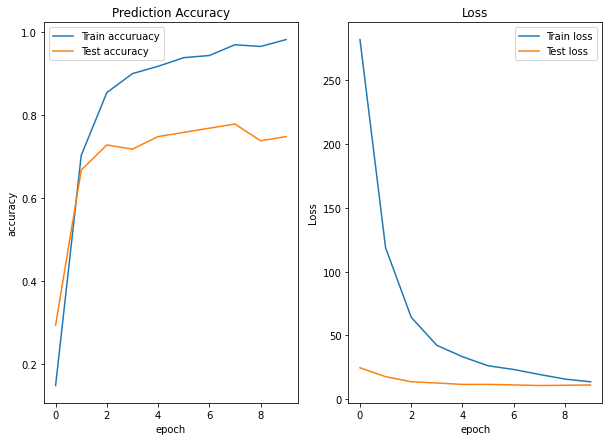

In [ ]:
from tqdm.notebook import tqdm_notebook

train_accs = []
test_accs = []

train_loss = []
test_loss = []

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 7))

for epoch in tqdm_notebook(range(10)):
  # Train loop
  train_loss_sum = 0
  train_total_correct = 0
  train_total = len(natural_scenes_train_set)
  for batch in natural_scenes_train_loader:
    images, labels = batch
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
    output = resnet(images)
    loss = loss_fn(output, labels)
    loss.backward()
    optimizer.step()
    train_loss_sum += loss.item()

    train_predictions = torch.argmax(output, dim=1)

    train_num_correct = torch.sum(train_predictions == labels)
    train_total_correct += train_num_correct
  

  train_loss.append(train_loss_sum)
  # Eval loop
  with torch.no_grad():
    test_loss_sum = 0
    test_total_correct = 0
    test_total = len(natural_scenes_test_set)
    for batch in natural_scenes_test_loader:
      images, labels = batch
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      output = resnet(images)
      loss = loss_fn(output, labels)
      test_loss_sum += loss.item()


      test_predictions = torch.argmax(output, dim=1)

      test_num_correct = torch.sum(test_predictions == labels)
      test_total_correct += test_num_correct

    # Plot accuracy
  test_loss.append(test_loss_sum)


  train_accs.append(train_total_correct / train_total)
  test_accs.append(test_total_correct / test_total)

axs[0].plot(train_accs, label="Train accuruacy")
axs[0].plot(test_accs, label="Test accuracy")
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('accuracy')
axs[0].set_title('Prediction Accuracy')
axs[0].legend()

axs[1].plot(train_loss, label="Train loss")
axs[1].plot(test_loss, label="Test loss")
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss')
axs[1].legend()
plt.show()

### What are the layers in the `resnet`

In [ ]:
children_counter = 0
for n,c in resnet.named_children():
    print("Children Counter: ",children_counter," Layer Name: ", n,)
    children_counter+=1

Children Counter:  0  Layer Name:  conv1
Children Counter:  1  Layer Name:  bn1
Children Counter:  2  Layer Name:  relu
Children Counter:  3  Layer Name:  maxpool
Children Counter:  4  Layer Name:  layer1
Children Counter:  5  Layer Name:  layer2
Children Counter:  6  Layer Name:  layer3
Children Counter:  7  Layer Name:  layer4
Children Counter:  8  Layer Name:  avgpool
Children Counter:  9  Layer Name:  fc


### What will be the dimensions of the output of each layer?

In [ ]:
from torchsummary import summary
summary(resnet.to(DEVICE), input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

### Full model architecture; detailed look at each `layer`

In [ ]:
for (name, layer) in resnet._modules.items():
    #iteration over outer layers
    print((name, layer))

('conv1', Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False))
('bn1', BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
('relu', ReLU(inplace=True))
('maxpool', MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False))
('layer1', Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): Ba

### Create `new_model` class for fetching feature vectors

In [ ]:
class new_model(nn.Module):
  
  def __init__(self, model, output_layer):
      super().__init__()

      self.output_layer = output_layer
      self.pretrained = model
      self.children_list = []
      
      for n,c in self.pretrained.named_children():
          self.children_list.append(c)
          if n == self.output_layer:
              break

      self.net = nn.Sequential(*self.children_list)
      self.pretrained = None
      
  def forward(self,x):
      x = self.net(x)
      return x

def get_feature_vectors(model, layer_name, image):

  model = new_model(model, output_layer=layer_name)
  model = model.to(DEVICE)
  output = model(image)
  output = torch.Tensor.cpu(output).detach().numpy()

  return output 

### Get feature vectors 

In [ ]:
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.485, 0.485,],
                                 std=[0.229, 0.229, 0.229])

resize = transforms.Resize((256, 256))
parent_dir = 'natural_scenes_dataset'
feature_vectors = pd.DataFrame(columns=[int(image_label) for image_label in image_labels])


for image_label in tqdm_notebook(image_labels):  

  directory = f"image{image_label}"
  path = os.path.join(parent_dir, directory)

  # 1. Load the image with Pillow library
  img = Image.open(path+f'/image_{image_label}.jpeg').convert('RGB')

  # 2. Create a PyTorch Variable with the transformed image
  t_img = normalize(to_tensor(resize(img))).unsqueeze(0).to(DEVICE)

  output = get_feature_vectors(resnet, "avgpool", t_img)
  feature_vectors.loc[:, int(image_label)] = output[0].reshape((output.shape[1], 1))[:, 0]

  0%|          | 0/118 [00:00<?, ?it/s]

In [ ]:
feature_vectors.head(3)

,72,96,109,105,89,3,108,16,7,46,110,111,82,8,57,49,112,79,31,75,2,73,103,56,114,83,47,94,88,90,92,91,59,87,27,34,98,63,43,20,...,22,12,58,78,26,85,76,44,48,30,19,14,116,102,80,62,28,50,21,18,60,5,9,77,64,11,104,4,71,23,99,13,10,54,106,24,81,100,68,86
0,0.387457,0.399802,0.367144,0.371802,0.383428,0.371600,0.377376,0.359121,0.346392,0.361338,0.375475,0.389006,0.367848,0.374202,0.352790,0.380226,0.349116,0.354257,0.391848,0.370799,0.343343,0.331716,0.397949,0.363431,0.385290,0.390991,0.361461,0.384649,0.332014,0.321390,0.322234,0.360709,0.429656,0.371165,0.355782,0.336424,0.391073,0.347756,0.390535,0.362656,...,0.351682,0.384646,0.354501,0.366159,0.350831,0.379663,0.367473,0.388260,0.382430,0.363625,0.345469,0.385008,0.392714,0.387501,0.398802,0.390405,0.380314,0.410371,0.364186,0.345321,0.379443,0.385687,0.338477,0.369039,0.355339,0.379915,0.355867,0.364427,0.374204,0.371224,0.368810,0.326772,0.382009,0.375727,0.380654,0.402187,0.384548,0.373978,0.337936,0.347849
1,0.581174,0.558327,0.563189,0.533858,0.523617,0.595709,0.519594,0.521942,0.521968,0.584413,0.523978,0.560059,0.510389,0.562604,0.532677,0.565189,0.550088,0.559964,0.584849,0.526269,0.537525,0.552956,0.573040,0.550164,0.572043,0.550834,0.562904,0.543158,0.504033,0.533117,0.516961,0.563714,0.601936,0.520996,0.501466,0.560805,0.530058,0.570033,0.494982,0.551354,...,0.508120,0.502660,0.590127,0.543434,0.558741,0.540067,0.528672,0.497934,0.552332,0.566531,0.549256,0.494359,0.542048,0.530173,0.515812,0.525752,0.575951,0.549257,0.537037,0.510293,0.511845,0.527395,0.524069,0.525910,0.536996,0.514077,0.581424,0.561282,0.511821,0.513629,0.568181,0.528842,0.481832,0.537475,0.518735,0.524572,0.523112,0.504477,0.515010,0.576833
2,0.498733,0.442096,0.527958,0.470343,0.469910,0.458385,0.431993,0.411819,0.465662,0.472030,0.531188,0.459781,0.490767,0.486005,0.453586,0.503616,0.483061,0.537529,0.479984,0.529960,0.432419,0.515307,0.480100,0.498162,0.494192,0.522947,0.483614,0.457273,0.498683,0.496828,0.435673,0.472126,0.465651,0.450376,0.452245,0.463307,0.465305,0.489516,0.461564,0.474961,...,0.422540,0.449114,0.510063,0.510712,0.513286,0.504434,0.472513,0.436538,0.466935,0.486409,0.466875,0.399045,0.493667,0.543643,0.494813,0.425545,0.453835,0.452882,0.509363,0.494243,0.474863,0.423131,0.496892,0.434745,0.444156,0.489458,0.506739,0.480347,0.457338,0.496001,0.484892,0.464941,0.411901,0.477643,0.459152,0.458343,0.445082,0.499761,0.524742,0.424490


# Linear Mapping

Choose visual cortex area from `vis_cortex_areas` 

In [ ]:
visual_cortex_area = 'VISp' #VISpm

## Aligning the feature vectors corresponding to observation IDs

In [ ]:
# sklearn library instead of original code. 
from sklearn import linear_model

design_array = design_matrix["spike count"]["natural_scenes"][visual_cortex_area]
pca_model, design_array = get_pca(design_array, 0.85)

unit_ids = list(design_array.columns)
stim_ids = list(design_matrix["spike count"]["natural_scenes"][visual_cortex_area].index.values)

X = pd.DataFrame(columns=stim_ids)

weights = pd.DataFrame(columns = unit_ids)

for stim_id in tqdm_notebook(stim_ids):
  mask = labels_df["natural_scenes"][labels_df["natural_scenes"]['stimulus_presentation_id'] == stim_id] ['frame'] 
  if int(mask) != -1: #don't use the blank presentation ID as it is not a column in the feature vector
    X.loc[:,int(stim_id)] = pd.Series(feature_vectors.loc[:, int(mask)])



  0%|          | 0/5950 [00:00<?, ?it/s]

###Get Observation IDs associated with blank presentation

In [ ]:
nan_obsIDs = X.columns[X.isna().any()].tolist()
nan_obsIDs_locs = [X.columns.get_loc(col) for col in nan_obsIDs]

## Getting the weights 

In [ ]:
regressor = linear_model.Ridge()

for unit_id in tqdm_notebook(unit_ids):
  y = design_array[unit_id].drop(nan_obsIDs_locs)
  y = y.to_numpy().reshape((-1, 1))
  X_input = X.dropna(axis=1,how='any')
  regressor.fit(X_input.T.to_numpy(), y)
  weights.loc[:,unit_id] = regressor.coef_[0]

  0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
weights.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.846826,0.252470,-0.036386,-0.107967,0.017278,0.050840,0.413494,-0.132335,0.279607,-0.171928,0.183395,0.094620,0.037337,0.044284,-0.030870,-0.062219,0.014845,0.071661,-0.036625
1,-0.791176,0.671152,-0.529657,-0.077044,-0.126583,-0.066445,-0.168418,0.451071,-0.088586,0.338003,-0.253337,-0.210570,0.121663,0.071477,-0.140126,0.140418,-0.048999,-0.005564,-0.126022
2,0.756459,-0.514083,0.312481,-0.445103,0.243386,-0.240827,-0.115268,-0.019324,-0.265847,0.043967,-0.088998,0.294619,-0.143817,-0.155991,-0.150400,-0.002216,0.089720,-0.035348,0.123101


TODO: figure out a way to save weights to CSVs or pickle

In [ ]:

weights.to_csv(f'weights_{visual_cortex_area}.csv') 
files.download(f'weights_{visual_cortex_area}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Dump weights to disc using `pickle` or `dill` libraries

if you got to this point without errors, you have covertly installed dill and pickle, so you don't need to worry about installing them. The following cells should run just fine. 


In [ ]:
import dill
import pickle

#### dump to disc

you can replace `dill` with `pickle` and the code should work just as well.

In [ ]:
with open(f"weights_{visual_cortex_area}.dill", "wb") as f:
	dill.dump(weights, f)

#### load from disc

In [ ]:
with open(f"weights_{visual_cortex_area}.dill", "rb") as f:
	weights = dill.load(f)

## Test learned `weights` on other session

### Get usual `spike_count` data. Also make `test_design_matrix` and obtain corresponding `test_labels`

In [ ]:
#test_session = get_session(vis_cortex_ids[3])

In [ ]:
#test_stimulus_table = test_session.get_stimulus_table()

In [ ]:
#neuron_types = vis_cortex_areas
#test_spike_data = get_spikes(test_session, neuron_types, stimulus_types, test_stimulus_table)


In [ ]:
# features = ["spike count"]
# stimulus_types = ["natural_scenes", "static_gratings"]
# test_design_matrix = build_matrix(test_session, stimulus_types, neuron_types, test_stimulus_table, features)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# test_labels_df = get_labels(test_design_matrix, stimulus_types)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# test_design_matrix["spike count"]["natural_scenes"][visual_cortex_area].shape

(5950, 102)

In [ ]:
# train_voxel_dims = design_array.shape[1]
# pca = PCA(n_components=train_voxel_dims)
# pca.fit(test_design_matrix["spike count"]["natural_scenes"][visual_cortex_area])
# test_design_array = pd.DataFrame(pca.transform(test_design_matrix["spike count"]["natural_scenes"][visual_cortex_area]))

In [ ]:
test_design_array

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,16.743039,-4.718376,2.629720,4.032526,5.957873,3.394746,-5.187513,1.066815,-1.258403,2.114730,3.198139,5.192180,-5.849740,4.993065,1.861199,-2.781729,-2.683825,1.335451,0.962367
1,-3.510509,-4.061184,-0.095818,2.849223,-0.720032,-0.666312,0.093346,-2.528867,-0.963944,0.218549,1.044599,2.177586,-0.375430,0.035460,1.580142,-2.291829,-3.619343,-0.714138,0.076507
2,5.782891,4.916258,-7.249578,8.485002,-0.869556,2.502583,3.126302,-1.903934,2.541470,1.845522,3.766725,1.455450,-5.577874,-0.173278,0.391789,-4.081165,-1.106069,-2.937525,-5.710450
3,25.036668,-5.192214,-0.372711,-3.875473,3.705939,4.746510,1.625598,1.481729,-7.696546,3.525771,6.091186,-5.284872,1.710716,1.434378,0.264281,-5.487437,-2.581995,-3.282618,2.817888
4,5.675383,-1.686257,0.016972,-2.841235,0.731510,-0.388121,-1.034757,5.751369,1.582927,-1.615592,3.845408,-0.338133,-1.149098,0.139631,-0.867520,-1.091348,1.824969,0.626855,-3.502128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5945,7.738538,-12.973617,-2.817097,-1.509740,1.691835,-3.107991,-0.033618,2.740966,0.406218,-1.661628,-0.775175,1.701767,4.054437,-0.384391,1.088797,2.330264,-1.114348,-0.595477,0.428178
5946,1.461436,-2.371085,3.872704,-5.155264,5.228476,2.382068,2.278540,-0.975373,-0.964182,3.122264,0.574794,-5.165596,2.254278,2.211779,2.872995,-0.930496,-1.082647,3.973705,-1.219789
5947,3.892465,-2.307749,-4.716860,-3.751254,-3.877009,-2.342514,-1.565990,-0.758128,0.593707,-0.944190,1.292594,0.233735,3.034045,2.385525,0.933636,6.043280,0.724063,3.159364,-1.813841
5948,10.305453,-6.545103,-4.362585,-0.727776,3.571840,-1.461584,2.808320,2.135562,0.475448,-2.115471,-3.636736,2.586361,-3.665245,2.432500,-0.067796,1.315130,0.801654,2.529599,-5.560693


In [ ]:
test_design_array.to_csv(f'test_design_array_{visual_cortex_area}.csv') 
files.download(f'test_design_array_{visual_cortex_area}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Encoded Feature Vectors

In [ ]:
weights = pd.read_csv(f'weights_{visual_cortex_area}.csv')
test_design_array = pd.read_csv(f'test_design_array_{visual_cortex_area}.csv')

In [ ]:
encoded_feature_vectors = test_design_array.to_numpy() @ weights.T.to_numpy()

In [ ]:
encoded_feature_vectors = pd.DataFrame(encoded_feature_vectors, index=stim_ids)

In [ ]:
encoded_feature_vectors = encoded_feature_vectors.drop(nan_obsIDs)

In [ ]:
encoded_feature_vectors.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
51355,-17.410103,-19.822495,16.619504,3.336979,-21.159885,16.120418,9.676950,-7.390574,-8.100209,10.610015,-7.705701,-10.542544,2.403160,-5.592003,-27.110323,-15.565026,-16.220145,-8.683670,-13.454980,-36.270243,-14.882441,3.969947,-40.702317,13.870831,-45.062827,46.870812,-23.009108,8.763345,-26.667404,-17.000722,25.380072,22.258587,-14.402447,-16.619387,4.720073,23.565771,9.174758,43.883295,29.139925,16.956975,...,13.028303,6.944077,17.829566,-4.669021,34.054998,4.574674,-0.744863,-6.320088,7.408503,-49.890247,8.973012,-4.074975,9.980185,0.368925,-18.537031,4.871016,0.912750,-4.385550,-29.127829,-6.442194,-9.703908,-6.003096,3.095585,-5.449048,3.021397,-17.746293,-54.812779,12.390577,-1.806918,9.485461,18.359553,-14.459475,8.049385,-2.238879,12.464459,-2.512710,-25.786013,6.030629,25.562282,5.215148
51356,2.034445,-1.116611,0.497705,4.679980,9.348280,1.787153,2.655980,3.752537,9.079796,11.831097,11.993982,10.420358,18.141371,10.864443,20.667617,19.036993,16.574941,19.689704,21.993696,22.266188,23.195686,23.389406,26.404214,24.623646,27.610792,17.509170,26.619015,29.748107,31.052404,28.035565,26.255745,27.208419,31.129722,37.186329,29.776332,30.694102,36.222463,33.966844,35.046226,41.399142,...,2003.953936,2008.709527,2008.710026,2011.707029,2007.194060,2011.753010,2013.097023,2016.536740,2018.446179,2025.194623,2021.363748,2021.384918,2017.429545,2019.141147,2025.805223,2022.060067,2025.505309,2024.789739,2026.857398,2028.824911,2030.169641,2026.276573,2029.344798,2030.076245,2033.753415,2032.838829,2040.032000,2035.484961,2033.119570,2032.304015,2037.444619,2041.141564,2036.924878,2044.227855,2042.583436,2043.492482,2048.778341,2045.768636,2042.407992,2047.234345
51357,-1.421391,1.077928,-1.752743,15.171780,9.249519,13.635820,21.425214,19.755911,12.901627,17.758704,17.974349,19.921567,25.392500,34.003159,22.077525,25.836320,28.016419,34.375821,38.905730,27.740529,43.001670,48.893024,20.654923,61.966295,22.571233,56.004539,44.947564,55.121918,52.295775,51.349734,65.483989,69.746723,61.993302,66.781939,67.918030,71.035141,76.358999,87.418598,92.450361,83.370555,...,4021.177662,4027.645858,4026.454699,4018.057384,4036.808511,4032.985034,4031.051887,4027.751266,4029.882707,4020.485854,4032.154104,4035.082961,4051.326427,4046.610555,4047.523750,4039.079850,4049.561610,4057.882528,4047.644697,4047.544927,4044.020693,4062.827165,4057.610559,4053.701122,4044.544607,4061.338747,4048.109669,4075.161385,4065.458599,4075.447250,4079.962006,4067.515054,4086.351282,4080.485490,4090.340890,4085.507216,4080.121211,4098.366326,4102.700750,4094.629077
51358,-23.356413,-19.451091,28.595737,12.825915,-21.834889,39.780237,35.412861,14.161304,9.012983,41.438647,16.843191,15.787660,27.582882,31.757431,-3.760950,12.307962,28.348942,35.781449,32.395876,6.640966,36.421528,67.331140,1.343309,84.553028,14.718099,140.812373,48.981149,86.939937,45.658845,67.340414,122.019684,122.268880,76.241385,74.667259,117.892713,140.481217,117.434159,171.031156,147.280597,133.203433,...,6045.906173,6039.371817,6058.793135,6027.599870,6092.704776,6047.731150,6038.549051,6034.442312,6054.960397,5978.697347,6069.817955,6044.417622,6074.500978,6066.214318,6043.035716,6069.414133,6078.985769,6074.587056,6038.616576,6071.398372,6067.369694,6079.089992,6089.735213,6084.953670,6090.746556,6078.795780,6030.996500,6115.300616,6106.332037,6131.528935,6142.156796,6092.497680,6128.530800,6118.144096,6137.552600,6126.681003,6095.298141,6138.374200,6175.275430,6148.692103
51359,-4.469873,-0.112662,13.762792,10.973439,7.131395,27.028507,27.553796,24.081992,30.651853,38.950098,36.377565,41.850654,44.208515,48.801167,43.493893,51.571536,59.267798,62.304010,65.932441,62.60391

In [ ]:
encoded_feature_vectors.shape

(5900, 2048)

# Reconstruct Images

### Create `VAE_decoder` class

In [ ]:
class VAE_decoder(nn.Module):
    def __init__(self, feat_size, output_dim=(1, 256, 256)):
        """
        Initializes the VAE decoder network.
        Optional args:
        - feat_size (int): size of the final features layer (default: 256)
        - output_dim (tuple): output image dimensions (channels, width, height) 
            (default: (1, 256, 256))
        """

        super().__init__()
        self.feat_size = feat_size
        self._vae = True
        self.output_dim = output_dim

        self.decoder_linear = nn.Sequential(
              nn.Linear(self.feat_size, 512),
              nn.ReLU(),
              nn.BatchNorm1d(512, affine=False),
              nn.Linear(512, 1024),
              nn.ReLU(),
              nn.BatchNorm1d(1024, affine=False),
              nn.Linear(1024, 59536),
              nn.ReLU()
        )
        self.decoder_conv = nn.Sequential(
              nn.UpsamplingNearest2d(scale_factor=2),
              nn.BatchNorm2d(16, affine=False),
              nn.ConvTranspose2d(
                  in_channels=16, out_channels=6, kernel_size=5, stride=1
                  ),
              nn.ReLU(),
              nn.UpsamplingNearest2d(scale_factor=2),
              nn.BatchNorm2d(6, affine=False),
              nn.ConvTranspose2d(
                  in_channels=6, out_channels=1, kernel_size=5, stride=1
                  )
        )

        self._test_output_dim()

    @property
    def vae(self):
        return self._vae

    def _test_output_dim(self):
        dummy_tensor = torch.ones(1, self.feat_size)
        reset_training = self.training
        self.eval()
        with torch.no_grad():
            decoder_output_shape = self.reconstruct(dummy_tensor).shape[1:]
        if decoder_output_shape != self.output_dim:
            raise ValueError(f"Decoder produces output of shape "
                f"{decoder_output_shape} instead of expected "
                f"{self.output_dim}.")
        if reset_training:
            self.train()

    def decode(self, z):
        h3 = self.decoder_linear(z.float())
        h3 = h3.view(-1, 16, 61, 61)
        recon_x_logits = self.decoder_conv(h3)
        return recon_x_logits

    def forward(self, X):
        z = X
        recon_x_logits = self.decode(z)
        return recon_x_logits

    def reconstruct(self, X):
        with torch.no_grad():
            recon_x = torch.sigmoid(self.decode(X))
        return recon_x


#### Specify VAE `loss_function`

In [ ]:
def vae_loss_function(recon_X_logits, X, beta=1.0):
    """
    vae_loss_function(recon_X_logits, X, mu, logvar)
    Returns the weighted VAE loss for the batch.
    Required args:
    - recon_X_logits (4D tensor): logits of the X reconstruction 
        (batch_size x shape of x)
    - X (4D tensor): X (batch_size x shape of x)
    - mu (2D tensor): mu values (batch_size x number of features)
    - logvar (2D tensor): logvar values (batch_size x number of features)
    Optional args:
    - beta (float): parameter controlling weighting of KLD loss relative to 
        reconstruction loss. (default: 1.0)
    
    Returns:
    - (float): weighted VAE loss
    """

    BCE = torch.nn.functional.binary_cross_entropy_with_logits(
        recon_X_logits, X, reduction="sum"
        )
    #KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE



#### Train VAE

In [ ]:
def train_vae(encoder, labels_df, image_dataset, dataset, train_sampler, num_epochs=10, batch_size=500, 
              beta=1.0,  use_cuda=True, verbose=False):
    """
    train_vae(encoder, dataset, train_sampler)
    Function to train an encoder using the SimCLR loss.
    
    Required args:
    - encoder (nn.Module): Encoder network instance for extracting features. 
        Should have method get_features().
    - dataset (dSpritesTorchDataset): dSprites torch dataset
    - train_sampler (SubsetRandomSampler): Training dataset sampler.
    
    Optional args:
    - num_epochs (int): Number of epochs over which to train the classifier. 
        (default: 10)
    - batch_size (int): Batch size. (default: 100)
    - beta (float): parameter controlling weighting of KLD loss relative to 
        reconstruction loss. (default: 1.0)
    - use_cuda (bool): If True, cuda is used, if available. (default: True)
    - verbose (bool): If True, 5 first batch reconstructions are plotted at 
        each epoch. (default: False)
    Returns: 
    - encoder (nn.Module): trained encoder
    - decoder (nn.Module): trained decoder
    - loss_arr (list): training loss at each epoch
    """

    device = "cuda" if use_cuda and torch.cuda.is_available() else "cpu"

    decoder = VAE_decoder(encoded_feature_vectors.shape[1] , (1, 256, 256)).to(device)

    # if not encoder.vae:
    #     raise ValueError("Must pass encoder for which self.vae is True.")

    train_dataloader = torch.utils.data.DataLoader(
        torch.tensor(encoded_feature_vectors.to_numpy()), batch_size=batch_size,
        )

    
    image_dataloader = torch.utils.data.DataLoader(
                        image_dataset, batch_size=batch_size)

    dataiter = iter(image_dataloader)
    images_loader, labels = dataiter.next()


    # Define loss and optimizers
    # train_params = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=500
        )

    # Train model on training set
    # reset_encoder_training = encoder.training
    # encoder.train()
    decoder.train()

    loss_arr = []
    for epoch in tqdm_notebook(range(num_epochs)):
        total_loss = 0
        num_total = 0
        for batch_idx, X in enumerate(train_dataloader):
            optimizer.zero_grad()
            recon_X_logits = decoder(X.to(device))


            start_idx = int(batch_idx*batch_size)
            end_idx = int(batch_size*(batch_idx + 1) - 1)

            if batch_idx == len(train_dataloader) - 1:
              image_labels = labels_df.loc[start_idx:, "frame"].tolist()
            else: 
              image_labels = labels_df.loc[start_idx: end_idx, "frame"].tolist()
            
            ims = np.zeros((X.shape[0], 1, 256, 256))

            for indx, image_label in enumerate(image_labels):
              ims[indx, :, :, :] = images_loader[int(image_label)].sum(0).unsqueeze(0)
            ims = torch.Tensor(ims)


            loss = vae_loss_function(
                recon_X_logits=recon_X_logits, X=ims.to(device), beta=beta
                )
            total_loss += loss.item()
            num_total += len(recon_X_logits)
            loss.backward()
            optimizer.step()
            if verbose and epoch % 10 == 9 and batch_idx == 0:
                num_images = 5
                # encoder.eval()
                decoder.eval()
                with torch.no_grad():
                    input_imgs = X[:num_images].detach().cpu().numpy()
                    output_imgs = decoder.reconstruct(
                                  input_imgs.to(device))\
                                  .detach().cpu().numpy()
                # encoder.train()
                decoder.train()

                title = (f"Epoch {epoch}, batch {batch_idx}, "
                    f"loss {loss.item():.2f}")
                plot_util.plot_dsprite_image_doubles(
                    list(input_imgs), list(output_imgs), "Reconstr.",
                    title=title)

        loss_arr.append(total_loss / num_total)
        scheduler.step()

    # set final decoder state and reset original encoder state
    decoder.train()
    decoder.cpu()
    # if reset_encoder_training:
    #     encoder.train()
    # else:
    #     encoder.eval()
    # encoder.to(reset_encoder_device)

    return decoder, loss_arr

In [ ]:
def get_images(labels_df):

  image_labels = list(labels_df["natural_scenes"]["frame"].unique())
  images = {}

  if -1 in image_labels:
    image_labels.remove(-1)

  for image_index in tqdm_notebook(image_labels):
    images[image_index] = cache.get_natural_scene_template(image_index)

  return images

In [ ]:
images = get_images(labels_df)

  0%|          | 0/118 [00:00<?, ?it/s]

In [ ]:
parent_dir = 'decoding_datasets'

transformations = [transforms.ToTensor(),                 
                  transforms.Resize((256, 256)),
                  transforms.ToPILImage()
                  ]

image_labels = list(labels_df["natural_scenes"]["frame"].unique())

if -1 in image_labels:
  image_labels.remove(-1)

for image_index in tqdm_notebook(image_labels):

  directory = f"image{image_index}"
  path = os.path.join(parent_dir, directory)

  if not os.path.exists(path):
    os.makedirs(path) 
  
  im = Image.fromarray(images[image_index])
  transform = transforms.Compose(transformations)
  transformed_image = transform(im)
  im = transform(im)
  im.save(path+f'/image_{image_index}.jpeg')

  0%|          | 0/118 [00:00<?, ?it/s]

In [ ]:
image_dataset = ImageFolder('decoding_datasets',
                              transform=train_transform)


In [ ]:
temp_labels_df = labels_df["natural_scenes"][labels_df["natural_scenes"]["frame"] != -1].reset_index()

In [ ]:
decoder, loss = train_vae(encoded_feature_vectors, temp_labels_df, image_dataset, dataset=None, train_sampler=None, num_epochs=100, 
                          batch_size=500, beta=1.0,  use_cuda=True, verbose=False)

  0%|          | 0/100 [00:00<?, ?it/s]

#### Vizualize reconstructions

In [ ]:
def get_model_device(model):
    """
    get_model_device(model)
    Returns the device that the first parameters in a model are stored on.
    N.B.: Different components of a model can be stored on different devices. 
    Thisfunction does NOT check for this case, so it should only be used when 
    all model components are expected to be on the same device.
    Required args:
    - model (nn.Module): a torch model
    Returns:
    - first_param_device (str): device on which the first parameters of the 
        model are stored
    """
    

    if len(list(model.parameters())):
        first_param_device = next(model.parameters()).device
    else:
        first_param_device = "cpu" # default if the model has no parameters

    return first_param_device


In [ ]:

def plot_vae_reconstructions(encoded_feature_vectors, decoder, batch_size, title=None, 
                             use_cuda=True):
    """
    plot_vae_reconstructions(encoder, decoder, dataset, indices)
    Plots VAE reconstructions from an encoder and decoder.
    Required args:
    - encoder (CoreEncoder): encoder with self.vae set to True.
    - decoder (VAE_decoder): VAE decoder
    - dataset (dSpritesTorchDataset): dSprites torch dataset
    - indices (array-like): dataset indices to plot
    Optional args:
    - title (str): Plot title. (default: None)
    - use_cuda (bool): If True, cuda is used, if available. (default: True)
    """

    device = "cuda" if use_cuda and torch.cuda.is_available() else "cpu"

    # if not (encoder.vae and decoder.vae):
    #     raise ValueError(
    #         "Must pass encoder and decoder for which self.vae is True."
    #         ) 

    # reset_encoder_device = get_model_device(encoder) # record for later
    reset_decoder_device = get_model_device(decoder)

    # Send to device
    # encoder = encoder.to(device)
    decoder = decoder.to(device)


    # reset_encoder_training = encoder.train() # record for later
    reset_decoder_training = decoder.train()

    # Retrieve reconstructions in eval mode
    # encoder.eval()
    decoder.eval()

    dataloader = torch.utils.data.DataLoader(
        torch.tensor(encoded_feature_vectors.to_numpy()), batch_size=batch_size,
        )

    Xs, recon_Xs = [], []
    for X in dataloader:
        with torch.no_grad():
            recon_X = decoder.reconstruct(
                X.to(device)
                ).detach()
            Xs.extend(list(X.cpu().numpy()))
            recon_Xs.extend(list(recon_X.cpu().numpy()))

    # reset original encoder and decoder states
    # if reset_encoder_training:
    #     encoder.train()
    # encoder.to(resiet_encoder_device)
    
    if reset_decoder_training:
        decoder.train()  
    decoder.to(reset_decoder_device)
    

    return list(recon_Xs)


In [ ]:
ret = plot_vae_reconstructions(
    encoded_feature_vectors,  # pre-trained encoder
    decoder,  # pre-trained decoder
    title="image reconstructions",
    batch_size=500
    )

In [ ]:
index = labels_df["natural_scenes"].loc[5800, "frame"]
index

114.0

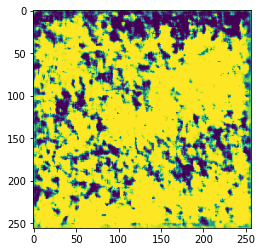

In [ ]:
plt.imshow(ret[5800].squeeze(0))

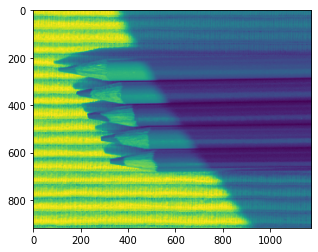

In [ ]:
plt.imshow(images[114])